In [1]:
import tensorflow as tf
import qkera_experiments.dataset as dataset
from tensorflow import keras
from keras import layers
from qkeras import *

# load the dataset

In [2]:
x_train, y_train, x_test, y_test = dataset.load_cifar10()

(50000, 1)


# define learning rate scheduler

In [3]:
class ResNetPaperLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr = 0.1, learning_rate_decay=10, steps=[32000, 48000]):
        super(ResNetPaperLR, self).__init__()
        self.initial_lr = initial_lr
        self.learning_rate_decay = learning_rate_decay
        self.steps = steps
        self.current_lr = 0
    def __call__(self, step):        
        step12 = tf.where(step < self.steps[1], self.initial_lr/self.learning_rate_decay, self.initial_lr/(self.learning_rate_decay**2))    
        step01 = tf.where(step < self.steps[0], self.initial_lr, step12)
        return step01
                         

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "learning_rate_decay": self.learning_rate_decay,
            "steps": self.steps
        }

# load the model

In [4]:
from qkeras.utils import load_qmodel


qmodel = load_qmodel("qmodels/resnet32/model.h5", custom_objects={"ResNetPaperLR":ResNetPaperLR})
qmodel.evaluate(x_test, y_test)

x_in = qmodel.layers[0].input
x_out = qmodel.layers[-2].output

base_model = keras.Model(inputs=[x_in], outputs=[x_out])
base_model.summary()

del qmodel

c:\Users\georg\Desktop\mestrado_luiz\deep_nibble_dnn\.venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 23s 48ms/step - loss: 1.3027 - accuracy: 0.6159
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 q_activation (QActivation)     (None, 32, 32, 3)    0           ['input[0][0]']                  
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 34, 34, 3)    0           ['q_activation[0][0]']           
                                                                                                  
 qconv1 (QConv2D)               (None, 32, 32, 16)   432         ['conv1_pad[0][0]']              
   

# including base model as a preprocessing component of the Deep Nibble MLP training

In [5]:
# preprocess the dataset
x_train_2 = base_model.predict(x_train)
print(x_train_2.shape)

1563/1563 [==============================] - 79s 46ms/step
(50000, 64)


In [6]:
# preprocess the dataset
x_test_2 = base_model.predict(x_test)
print(x_test_2.shape)

313/313 [==============================] - 14s 45ms/step
(10000, 64)


In [13]:
import numpy as np
import tensorflow as tf
from mlp_from_scratch.NeuralNetwork import QNeuralNetworkWithScale


# Define neural network inputnoutput
input_size = x_train_2.shape[1]
output_size = y_train.shape[1]

print(x_train_2.shape, x_test_2.shape, y_train.shape, y_test.shape)

# Create and train the neural network
neural_network_with_scale = QNeuralNetworkWithScale(input_size, output_size)

(50000, 64) (10000, 64) (50000, 10) (10000, 10)


# training Deep Nibble

In [14]:
# train the nn
# neural_network_with_scale.train(x_train_2, y_train, learning_rate=0.000010, num_epochs=1, batch_size=256, x_val=x_test_2, y_val=y_test)
neural_network_with_scale.train(x_train_2, y_train, learning_rate=0.000100, num_epochs=5, batch_size=256, x_val=x_test_2, y_val=y_test)
neural_network_with_scale.train(x_train_2, y_train, learning_rate=0.000010, num_epochs=15, batch_size=256, x_val=x_test_2, y_val=y_test)


Epoch 1/5, Loss: 0.006546387914568186 Accuracy: 23.530000686645508%
Epoch 2/5, Loss: 0.007528732996433973 Accuracy: 24.799999237060547%
Epoch 3/5, Loss: 0.011214996688067913 Accuracy: 36.16999816894531%
Epoch 4/5, Loss: 0.00926175806671381 Accuracy: 57.93000030517578%
Epoch 5/5, Loss: 0.01602875627577305 Accuracy: 54.87999725341797%
Epoch 1/15, Loss: 0.015406226739287376 Accuracy: 55.86000061035156%
Epoch 2/15, Loss: 0.015352138318121433 Accuracy: 56.66999816894531%
Epoch 3/15, Loss: 0.014516085386276245 Accuracy: 55.540000915527344%
Epoch 4/15, Loss: 0.013904957100749016 Accuracy: 56.900001525878906%
Epoch 5/15, Loss: 0.012700204737484455 Accuracy: 58.189998626708984%
Epoch 6/15, Loss: 0.01266517210751772 Accuracy: 56.98999786376953%
Epoch 7/15, Loss: 0.012472511269152164 Accuracy: 57.880001068115234%
Epoch 8/15, Loss: 0.012538429349660873 Accuracy: 57.05000305175781%
Epoch 9/15, Loss: 0.012743664905428886 Accuracy: 57.76000213623047%
Epoch 10/15, Loss: 0.012745091691613197 Accuracy: 

# training fp32

In [9]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  elif epoch < 5:
    return 0.01
  else:
    return 0.001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


x = x_in = keras.layers.Input((64))
x = keras.layers.Dense(units=256, activation="relu")(x)
x = keras.layers.Dense(units=256, activation="relu")(x)
x = keras.layers.Dense(units=10)(x)
fp_model = keras.Model(inputs=x_in, outputs=x)
fp_model.compile(keras.optimizers.SGD(learning_rate=0.001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
fp_hist = fp_model.fit(x_train_2, y_train, batch_size=256, epochs=20, validation_data=(x_test_2, y_test), callbacks=[callback])



Epoch 1/20
196/196 [==============================] - 1s 2ms/step - loss: 2.2829 - accuracy: 0.1102 - val_loss: 2.2460 - val_accuracy: 0.1774 - lr: 0.0010
Epoch 2/20
196/196 [==============================] - 0s 2ms/step - loss: 1.8414 - accuracy: 0.5956 - val_loss: 1.6074 - val_accuracy: 0.5943 - lr: 0.0100
Epoch 3/20
196/196 [==============================] - 0s 2ms/step - loss: 1.1902 - accuracy: 0.7910 - val_loss: 1.2237 - val_accuracy: 0.6188 - lr: 0.0100
Epoch 4/20
196/196 [==============================] - 0s 2ms/step - loss: 0.8250 - accuracy: 0.8225 - val_loss: 1.0903 - val_accuracy: 0.6252 - lr: 0.0100
Epoch 5/20
196/196 [==============================] - 0s 2ms/step - loss: 0.6567 - accuracy: 0.8331 - val_loss: 1.0568 - val_accuracy: 0.6288 - lr: 0.0100
Epoch 6/20
196/196 [==============================] - 0s 2ms/step - loss: 0.6011 - accuracy: 0.8367 - val_loss: 1.0542 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 7/20
196/196 [==============================] - 0s 2ms/step - lo

# training po2

In [16]:
def scheduler(epoch):
  if epoch < 1:
    return 0.0001
  elif epoch < 5:
    return 0.001
  else:
    return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


x = x_in = keras.layers.Input((64))
x = QActivation(activation="quantized_relu_po2(4,1, use_stochastic_rounding=True)")(x)
x = QDense(units=256, kernel_quantizer=quantized_po2(4,1, use_stochastic_rounding=True), bias_quantizer=(quantized_po2(4,1, use_stochastic_rounding=True)))(x)
x = QActivation(activation="quantized_relu_po2(4,1, use_stochastic_rounding=True)")(x)
x = QDense(units=256, kernel_quantizer=quantized_po2(4,1, use_stochastic_rounding=True), bias_quantizer=(quantized_po2(4,1, use_stochastic_rounding=True)))(x)
x = QActivation(activation="quantized_relu_po2(4,1, use_stochastic_rounding=True)")(x)
x = QDense(units=10, kernel_quantizer=quantized_po2(4,1, use_stochastic_rounding=True), bias_quantizer=(quantized_po2(4,1, use_stochastic_rounding=True)))(x)
x = QActivation(activation=quantized_bits(4, 0, 1, use_stochastic_rounding=False))(x)
qmodel = keras.Model(inputs=x_in, outputs=x)
qmodel.compile(keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

q_hist = qmodel.fit(x_train_2, y_train, batch_size=256, epochs=20, validation_data=(x_test_2, y_test), callbacks=[callback])



Epoch 1/20
196/196 [==============================] - 2s 7ms/step - loss: 2.5085 - accuracy: 0.0929 - val_loss: 2.4777 - val_accuracy: 0.0915 - lr: 1.0000e-04
Epoch 2/20
196/196 [==============================] - 1s 5ms/step - loss: 2.3292 - accuracy: 0.1276 - val_loss: 2.2188 - val_accuracy: 0.1977 - lr: 0.0010
Epoch 3/20
196/196 [==============================] - 1s 5ms/step - loss: 2.0986 - accuracy: 0.3162 - val_loss: 2.0580 - val_accuracy: 0.3604 - lr: 0.0010
Epoch 4/20
196/196 [==============================] - 1s 5ms/step - loss: 1.9190 - accuracy: 0.5016 - val_loss: 1.9277 - val_accuracy: 0.4682 - lr: 0.0010
Epoch 5/20
196/196 [==============================] - 1s 5ms/step - loss: 1.7765 - accuracy: 0.6083 - val_loss: 1.8224 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 6/20
196/196 [==============================] - 1s 5ms/step - loss: 1.7076 - accuracy: 0.6511 - val_loss: 1.8172 - val_accuracy: 0.5246 - lr: 1.0000e-04
Epoch 7/20
196/196 [==============================] - 1s 5ms/s

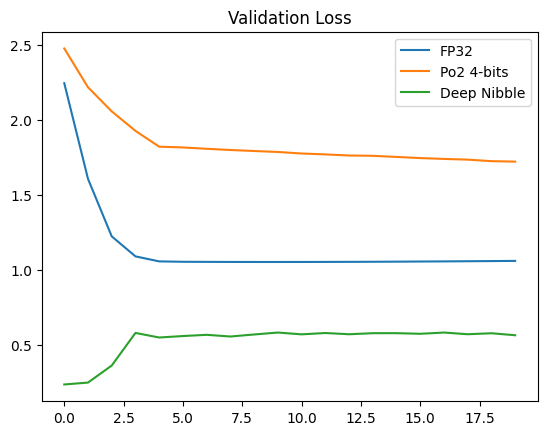

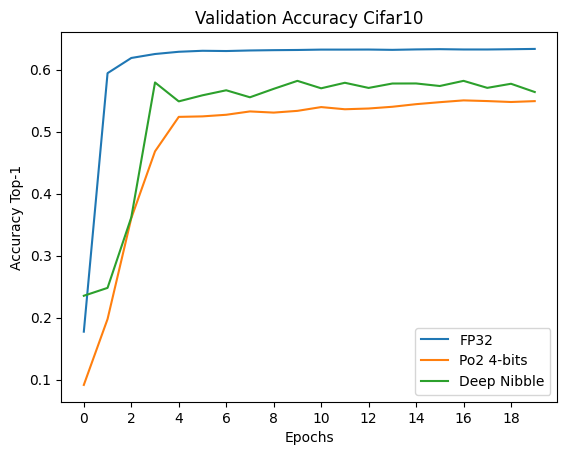

In [17]:
import matplotlib.pyplot as plt



#plt.plot(history.history["loss"])
plt.plot(fp_hist.history["val_loss"], label='FP32')
plt.plot(q_hist.history["val_loss"], label='Po2 4-bits')
plt.plot(neural_network_with_scale.acc_hist, label='Deep Nibble')
plt.legend()
plt.title('Validation Loss')
plt.show()    
#plt.plot(history.history["accuracy"])
plt.plot(fp_hist.history["val_accuracy"], label='FP32')
plt.plot(q_hist.history["val_accuracy"],  label='Po2 4-bits')
plt.plot(neural_network_with_scale.acc_hist, label='Deep Nibble')
plt.legend()
plt.title('Validation Accuracy Cifar10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Top-1')
plt.xticks(range(0, 20, 2))

plt.show()    

In [ ]:
print(np.array(neural_network_with_scale.acc_hist))